# CNN model with MNIST

## Get to know with Cov and Pooling

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root = './Data', train=True,download=True,transform=transform)
test_data = datasets.MNIST(root = './Data', train=False,download=True,transform=transform)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

In [7]:
# 1 color channel, 6 filters (output chanels), 3by3 lernel, Stride=1
# input, output, kernel size, stride 
conv1 = nn.Conv2d(1,6,3,1) # ---> 6 filters --> pooling ---> conv2

# 6 input filter Conv1, 16 filters, kernel size 3 by3, stride=1
conv2 = nn.Conv2d(6,16,3,1)

In [8]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [9]:
print(X_train.shape) #----> 4D (batch of 1 image)
x = X_train.view(1, 1, 28, 28)
print(x.shape) #----> 4D (batch of 1 image)

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [10]:
x = F.relu(conv1(x))

In [11]:
x.shape
#  1 = image, 6 = filter, 26 26 -> pading = 0 

torch.Size([1, 6, 26, 26])

In [12]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 6, 13, 13])

In [13]:
x = F.relu(conv2(x))

In [14]:
x.shape

torch.Size([1, 16, 11, 11])

In [15]:
x = F.max_pool2d(x,2,2)

In [16]:
x.shape #11/2 => 5.5

torch.Size([1, 16, 5, 5])

In [17]:
((((28-2)/2)-2)/2) # 5.5 => 5

5.5

In [18]:
x.shape

torch.Size([1, 16, 5, 5])

In [19]:
x.view(-1,16*5*5).shape
# -1 => keep first one

torch.Size([1, 400])

----

## CNN model 

In [20]:
class ConvolutionalNetwork(nn.Module):
    """Some Information about ConvolutionalNetwork"""
    def __init__(self, input_size = 1,output_size=10):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3,1)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [39]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [40]:
# cal parameter
sum_param = 0
for param in model.parameters():
    sum_param += param.numel()
    print(param.numel())

print(f'Sum param: {sum_param}')

54
6
864
16
48000
120
10080
84
840
10
Sum param: 60074


In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [43]:
import time 
start_time = time.time()
# Valiable (tackers)

epochs = 10
train_loss = []
test_loss = []
train_correct = []
test_correct = []


# For loop epochs
for epoch in range(epochs):
    
    trn_corr = 0
    tst_corr = 0

    # Train 
    for batch, (X_train, y_train) in enumerate(train_loader):
        batch += 1

        y_pred = model(X_train) # Not Flatten -> CNN 2D
        loss = criterion(y_pred,y_train)

        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum() #True 1/ False 0sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%600 == 0:
            accuracy = trn_corr.item()*100/ (10*batch)
            print(f'Epoch: {epoch+1} batch: {batch} loss: {loss.item():.3f} accuracy: {accuracy:.3f}')
            # print(f"Epoch: {epoch} Batch: {batch} Loss: {loss.item()}")
    
    train_loss.append(loss)
    train_correct.append(trn_corr)
    # Test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)

            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_pred)
        test_loss.append(loss)
        test_correct.append(tst_corr)
    

total_time = time.time() - start_time
print(f"total_time : {total_time/60} mins")

Epoch: 1 batch: 600 loss: 0.059 accuracy: 95.817
Epoch: 1 batch: 1200 loss: 0.097 accuracy: 96.025
Epoch: 1 batch: 1800 loss: 0.022 accuracy: 96.150
Epoch: 1 batch: 2400 loss: 0.057 accuracy: 96.371
Epoch: 1 batch: 3000 loss: 0.506 accuracy: 96.447
Epoch: 1 batch: 3600 loss: 0.531 accuracy: 96.572
Epoch: 1 batch: 4200 loss: 0.006 accuracy: 96.702
Epoch: 1 batch: 4800 loss: 0.187 accuracy: 96.800
Epoch: 1 batch: 5400 loss: 0.000 accuracy: 96.854
Epoch: 1 batch: 6000 loss: 0.130 accuracy: 96.933
Epoch: 2 batch: 600 loss: 0.002 accuracy: 98.317
Epoch: 2 batch: 1200 loss: 0.003 accuracy: 98.183
Epoch: 2 batch: 1800 loss: 0.004 accuracy: 98.078
Epoch: 2 batch: 2400 loss: 0.002 accuracy: 98.058
Epoch: 2 batch: 3000 loss: 0.273 accuracy: 98.000
Epoch: 2 batch: 3600 loss: 0.007 accuracy: 98.047
Epoch: 2 batch: 4200 loss: 0.061 accuracy: 98.079
Epoch: 2 batch: 4800 loss: 0.032 accuracy: 98.110
Epoch: 2 batch: 5400 loss: 0.002 accuracy: 98.113
Epoch: 2 batch: 6000 loss: 0.000 accuracy: 98.130
Ep

Train using CPU

## CNN Evaluation

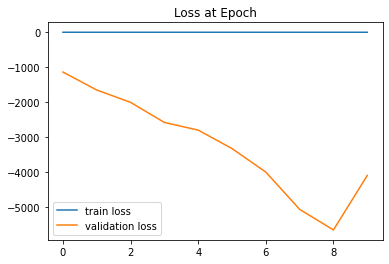

In [49]:
train_loss_np = [ts.item() for ts in train_loss]
test_loss_np = [ts.item() for ts in test_loss]
plt.plot(train_loss_np, label="train loss")
plt.plot(test_loss_np, label="validation loss")
plt.title("Loss at Epoch")
plt.legend()

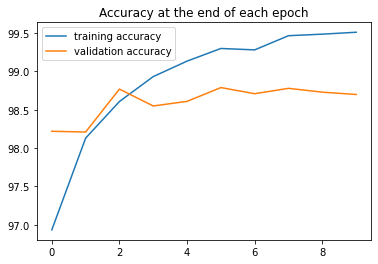

In [50]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [44]:
test_load_all = DataLoader(test_data, batch_size=10000,shuffle=False)

In [45]:
with torch.no_grad():
    correct = 0
    for X_test,y_test in test_load_all:
        y_val = model(X_test)
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [46]:
correct.item()/len(test_data)

0.987

In [51]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 971    0    0    0    0    1    2    0    1    0]
 [   0 1122    0    2    0    0    1    1    0    0]
 [   0    1 1016    1    0    0    0    4    1    0]
 [   0    1    3 1000    0    7    0    0    3    1]
 [   0    2    1    0  973    0    1    0    1    9]
 [   1    2    0    4    0  881    3    0    4   10]
 [   3    4    0    0    6    2  950    0    0    0]
 [   2    3   10    2    1    1    0 1018    2    6]
 [   2    0    1    1    0    0    1    1  959    3]
 [   1    0    1    0    2    0    0    4    3  980]]


7


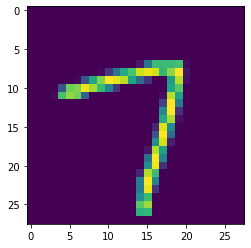

In [61]:
print(test_data[852][1])
plt.imshow(test_data[852][0].reshape(28,28))

In [62]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[852][0].view(1,1,28,28))

In [63]:
new_prediction

tensor([[-39.5859, -25.5054, -20.8868, -19.0143, -21.3030, -29.2860, -50.7566,
           0.0000, -28.6984, -22.4880]])

In [64]:
new_prediction.argmax()

tensor(7)

In [65]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

130

In [66]:
# Display the first 10 index positions
misses[:10]

array([ 247,  320,  321,  359,  445,  542,  582,  583,  659,  691],
      dtype=int64)

In [67]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [ 247  320  321  359  445  542  582  583  659  691  716  924]
Label: [   4    9    2    9    6    8    8    2    2    8    1    2]
Guess: [   6    8    7    4    0    9    2    7    7    4    7    7]


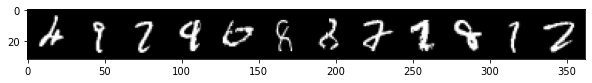

In [68]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [70]:
torch.cuda.is_available()

True

In [71]:
torch.cuda.current_device()

0

In [72]:
torch.cuda.get_device_name(0)

'GeForce GTX 1650'